# Identifying the heat conductivity of a wall with Bayesian Inference

This page is a tutorial on Bayesian inference applied to the characterisation of the thermal conductivity of a wall under uncertainty, using the [pymc](http://docs.pymc.io/) python library. This notebook uses [pymc 2.3.6](http://pymc-devs.github.io/pymc/), although conversion to a more recent version should not be an issue.

This is not an introduction to Bayesian inference or to its python implementation pymc. There is a lot of online material on these topics, and I advise [this great book](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/) if you are getting started into Bayesian statistics for non-mathematicians. This guide is more of an example case on how to integrate grey-box or black-box function evaluations into the inference algorithm.

## 1. Introduction

Consider the classic Inverse Heat Conduction Problem (IHCP) illustrated here:

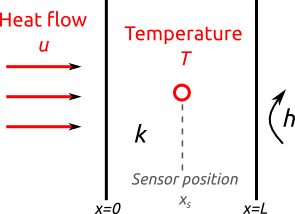

In [1]:
from IPython.display import Image
Image(filename='figures/IHCP.png', width = 240)

The problem is one-dimensional heat conduction inside a wall of thermal conductivity $k$. One boundary is subjected to a heat flow $u$ while the other boundary is either insulated ($h=0$) or open ($h>0$). A temperature sensor is placed at a certain location $x_c$ within the medium. The initial temperature is uniform $T_0 = 0^{\circ}C$.

A very usual form of sollicitation (heat flow), and its resulting temperature profile in the middle of the wall, in the case of an insulated wall ($h=0$), may look like this:

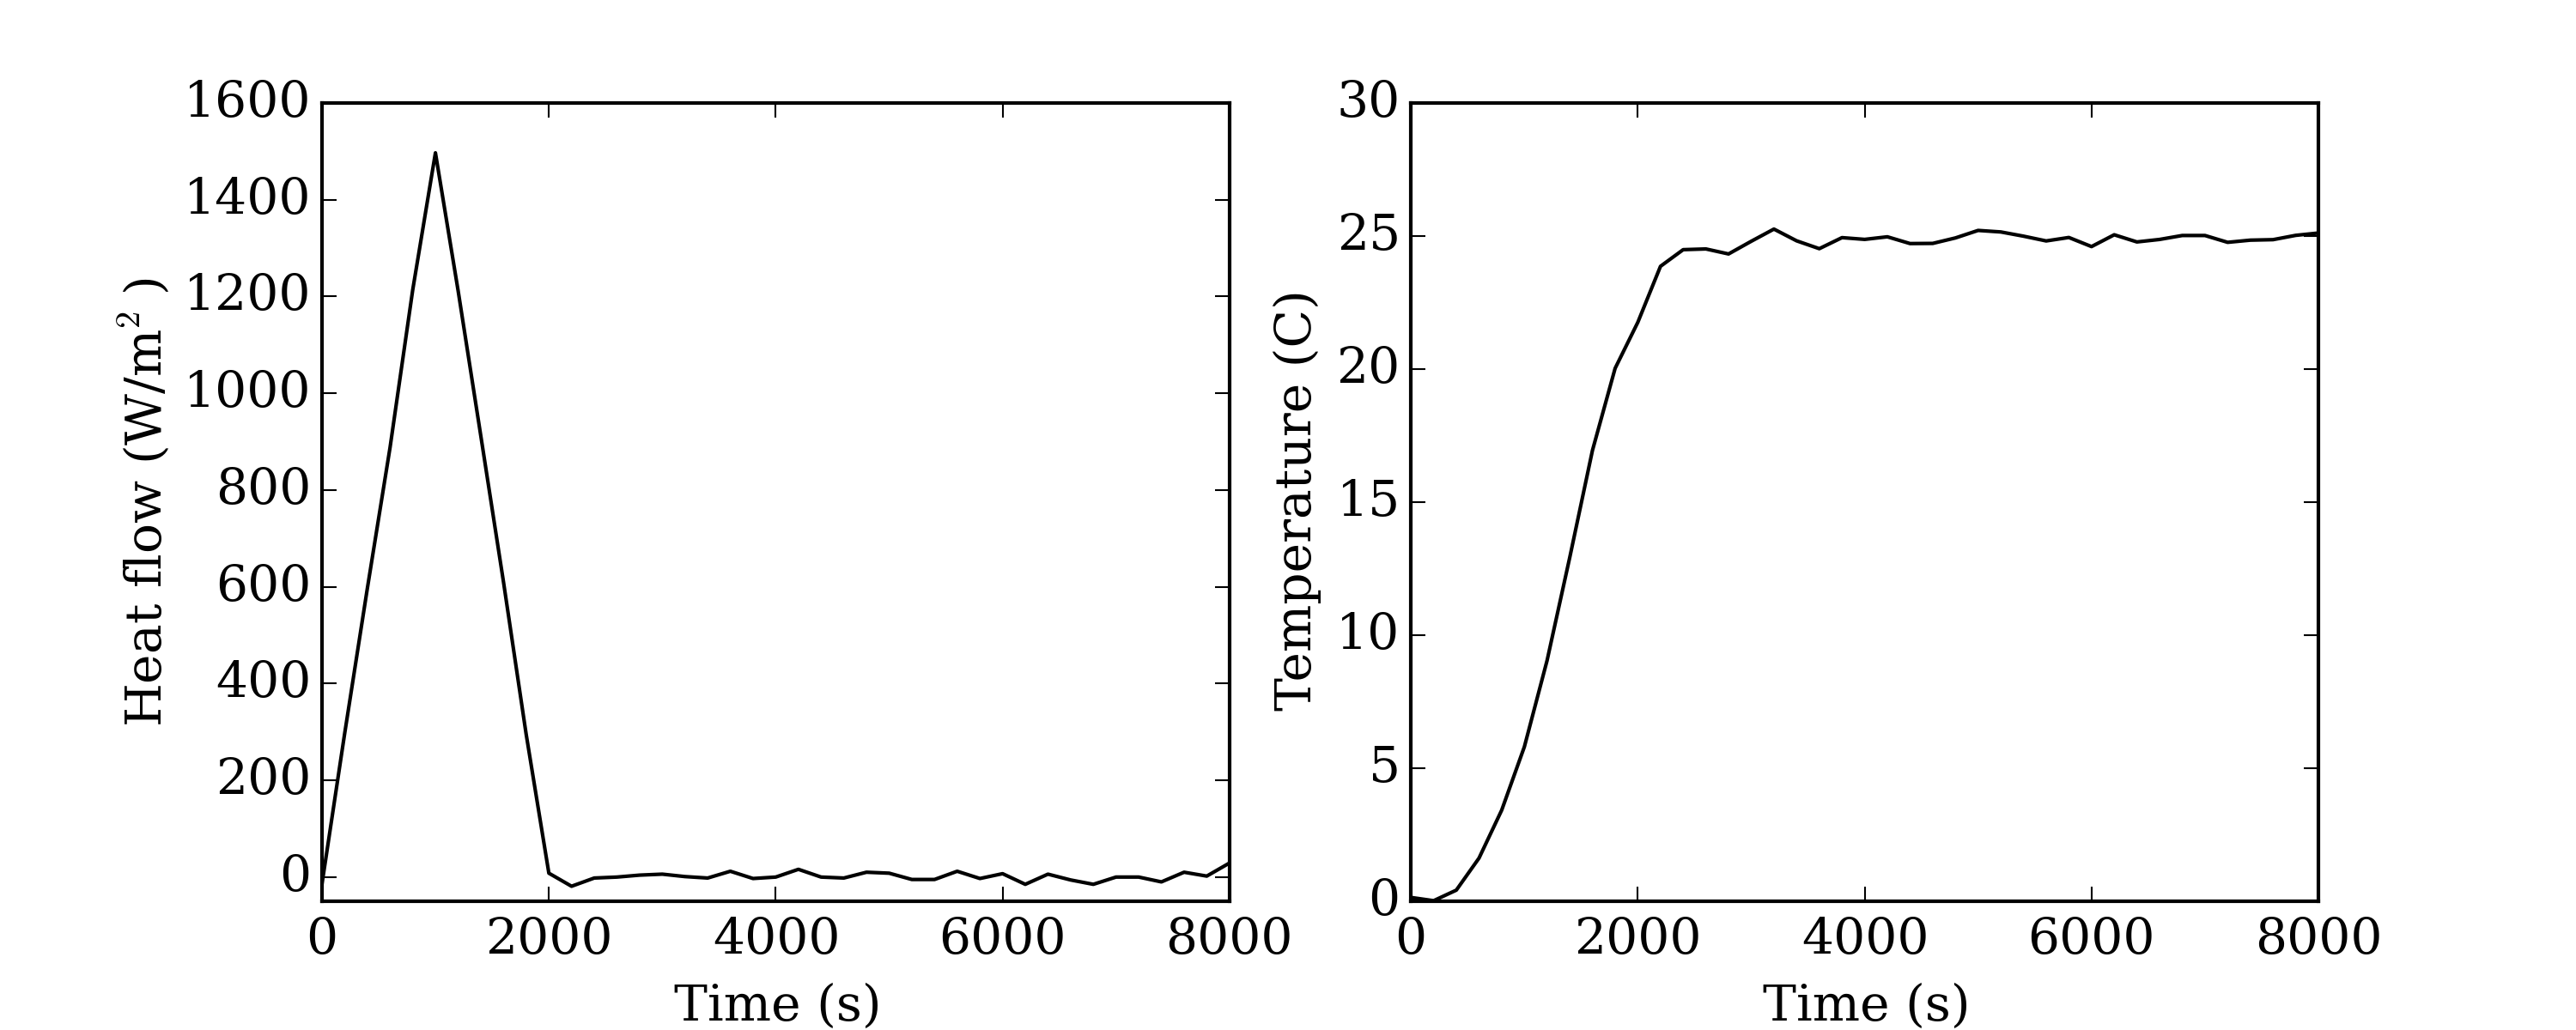

In [2]:
Image(filename='figures/input_output.png', width = 600)

Note that the data is noisy, which is essential in any interesting tutorial on inverse methods (we will get back to that below).

In the standard IHCP, the boundary heat flow is unknown and the target is to reconstruct it from the temperature records. The heat conductivity, sensor position and convection coefficient are known assumptions of the problem. The present tutorial however shows another alternative of the IHCP: the heat flow and the temperature are known, and the target is to characterise the thermal conductivity of the material. In order to make things a bit more complicated (and therefore interesting), we are considering **4 unknowns**:
* the thermal conductivity $k$, of course;
* the sensor position $x_s$ is known *a priori*, but may be a bit uncertain: let's include it in the inference;
* some white noise is included in the measurements of the heat flow and temperature. We can estimate the standard deviations of the noise components, respectively denoted $\sigma^u$ and $\sigma^T$.

The problem can be summarised in the following Bayesian network (this sketch was drawn using the using the [daft](http://daft-pgm.org/) python library):

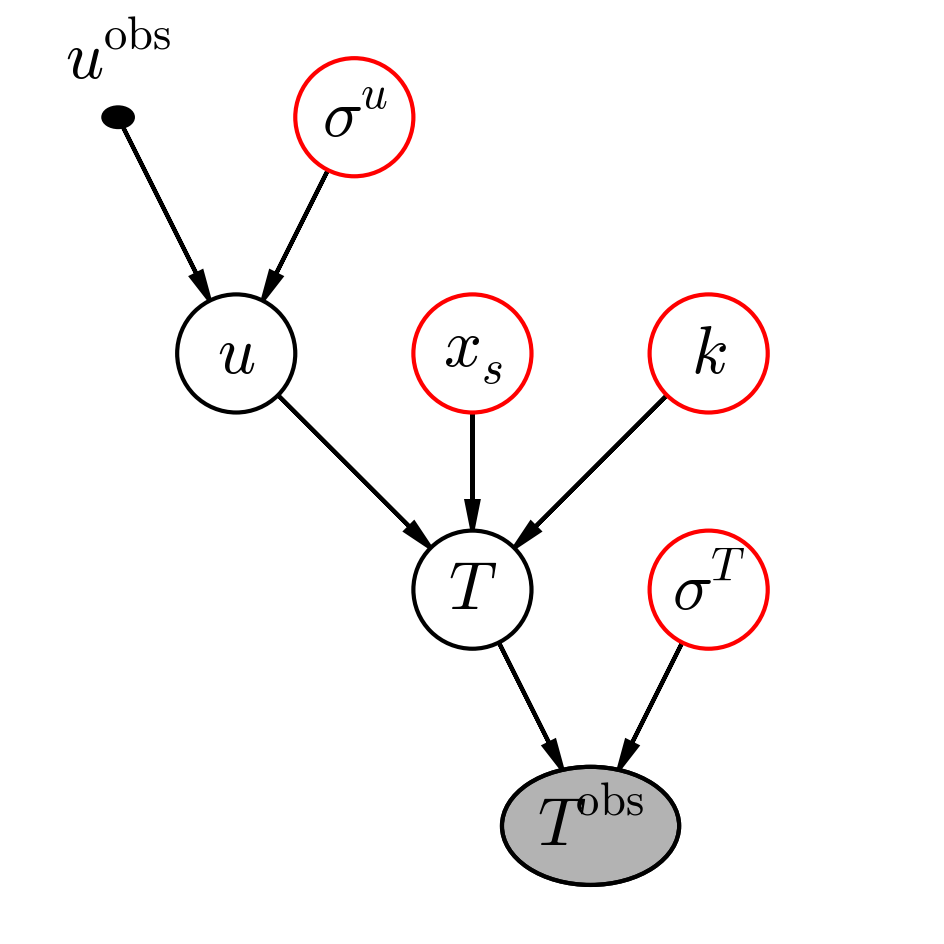

In [3]:
Image(filename = 'figures/drawing_tree_conductivity.png', width = 250)

This network can be read from top to bottom as follows:
* The **real** heat flow $u$ is unknown: its parents are the observed heat flow $u^\mathrm{obs}$ and the standard deviation of its white noise component $\sigma^u$.
* The **real** temperature at the sensor position is unknown. It is entirely defined by the real heat flow, the sensor position and the thermal conductivity, all of which are unknown.
* The **observed** temperature $T^\mathrm{obs}$ is not the real one: we must account for some measurement noise of standard deviation $\sigma^T$.

All initially available data is contained within the fixed parent variable $u^\mathrm{obs}$ and the final child variable $T^\mathrm{obs}$, neither of which is exactly equal to the real physical value of the heat flow or the temperature. The outcome of the inference are the parent nodes shown in red.

This is where some of the potential of Bayesian inference can be illustrated: any value can be considered unknown, and the effect of all prior uncertainties on the outcome can be estimated. For instance, supposing a certain structure for the noise, we can include it in the inference model structure and see its effects on the uncertainty of the final results of the identification. This is done here in the simple case of white noise, but the possibility for additional sources of uncertainty may be added, such as a systematic measurement error on a sensor. Second example: in order to show that we are not entirely sure of the exact position of the temperature sensor within the wall, this position may be added as an uncertain value with a more or less narrow prior distribution. This means that the sensor position should be explicitely used as a parameter when calling the deterministic function for temperature calculation (see below).

## 2. Code for the inference

All files used within this tutorial are available in the [BAYREB](https://github.com/locie/bayreb) repository that you can clone or download.

### Setting up the network

Let's start by saving the true value of the unknown parameters. This will be the reference for judging the accuracy of the identification.

In [4]:
xs_true       = 0.05 / 2  # sensor position
k_true        = 0.3       # thermal conductivity
sigma_T_true  = 0.2       # temperature noise
sigma_u_true  = 10        # heat flow noise

Next, we import measurement data for the heat flow and temperature, and add white noise to make it slightly more realistic. This is where we use the real values of $\sigma^T$ and $\sigma^u$. The following lines read the ideal heat and temperature profiles within the text file, and adds a normal random component of zero mean and known deviation.

In [5]:
import numpy as np
import pandas

data_file = pandas.read_csv('inputs.txt', delimiter='\t')
time_file = data_file['t (s)']

u_file    = np.array( data_file['U (W/m2)'] )
u_file   += np.random.normal(0, sigma_u_true, size=np.size(u_file))
T_file    = np.array( data_file['T(e/2)'] )
T_file   += np.random.normal(0, sigma_T_true, size=np.size(T_file))

Next, we define the prior probability distributions for each of the 4 unknowns. This is where the first call to the [pymc](http://pymc-devs.github.io/pymc/) module occurs, so it obviously has to be installed first (see the package's repository and website for help).

The prior probability distribution of a variable indicates in what range we *believe* its value is. This is where the subjective part of the work occurs, since Bayesian inference relies on expert knowledge as much as on objective sensor data. Choosing a good prior is not always trivial, and I do not aim at giving guidelines on how to do it. The basic requirements are that we should integrate as much expert knowledge as possible in order to put some constraints on the search space, without compromising the chances of any possible solution.

Three types of probability distributions are used here:
* we only have a vague idea of the possible range of $k$ and $\sigma^u$: let's start with **uniform** distributions for them;
* we are quite certain of the sensor position $x_s$, but it might be a bit off: a **normal** distribution seems a good choice;
* the temperature noise $\sigma^T$ is probably low, but it *might* be higher than we expect: an **exponential** distribution seems right.

Here is a graph of these prior distributions, compared to the true value of the parameters that we aim at getting back through the inference.

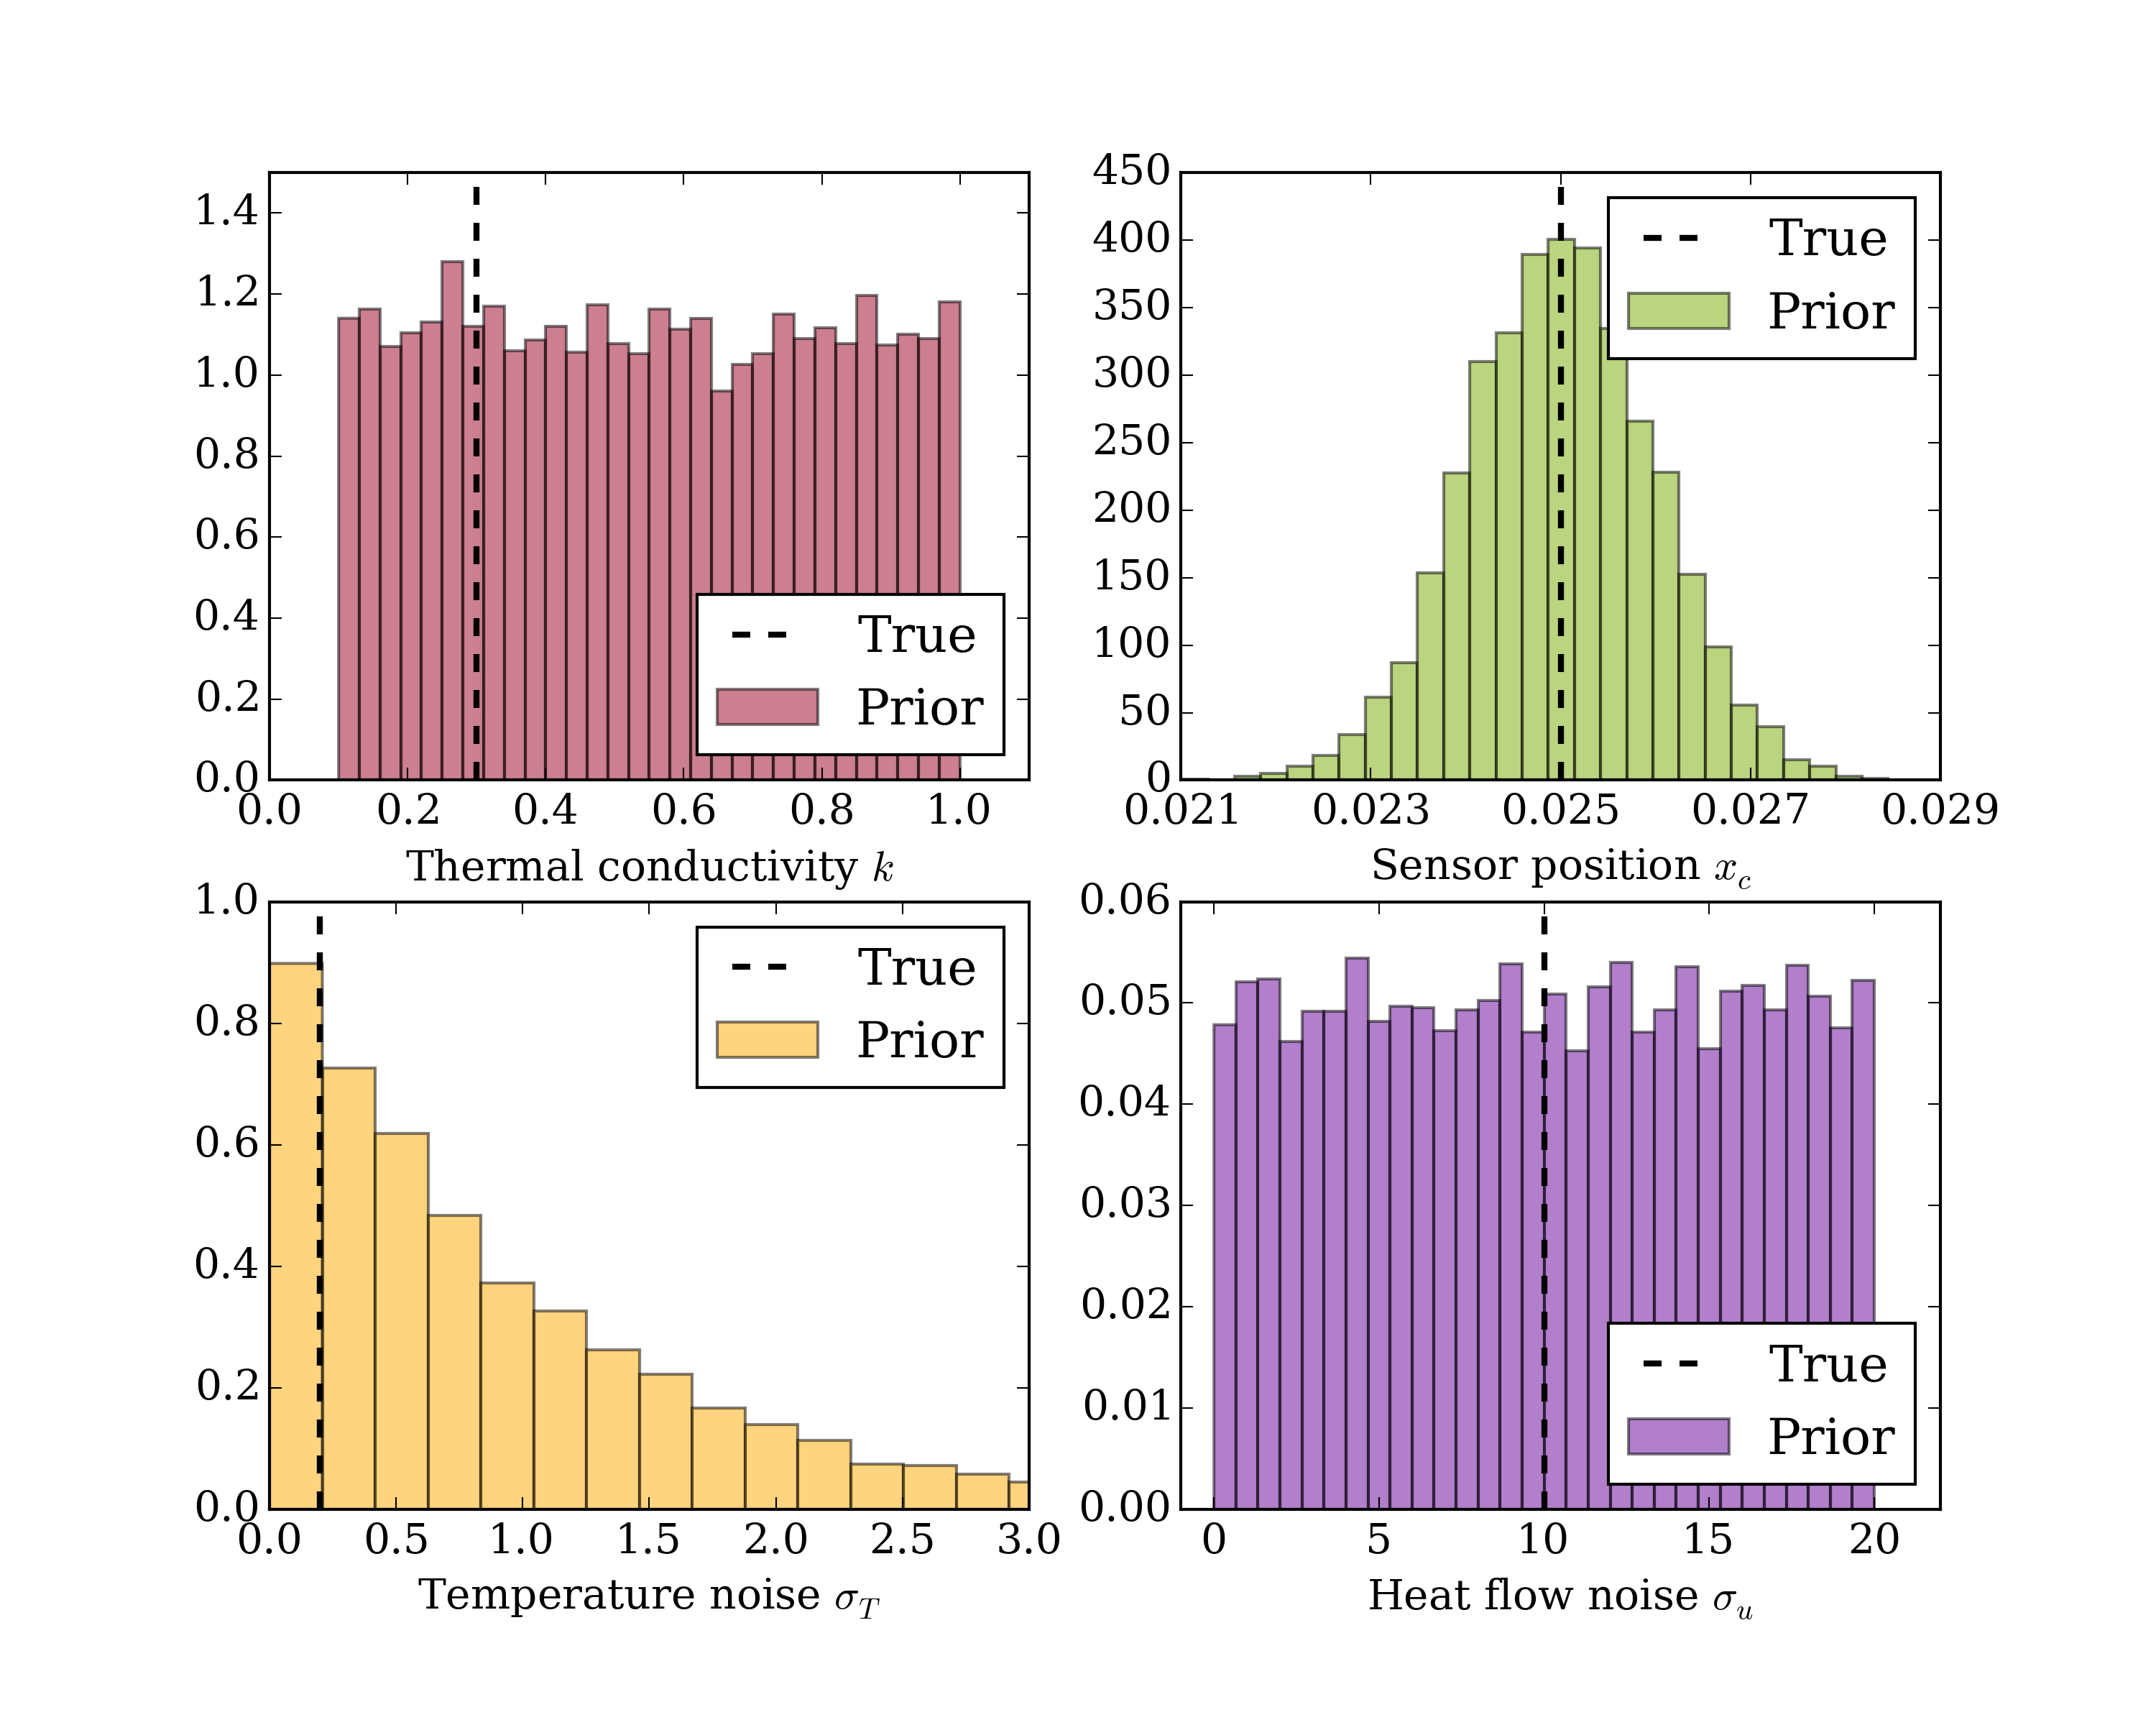

In [6]:
import pymc as pm

k_pm       = pm.Uniform("conductivity", 0.1, 1)
xs_pm      = pm.Normal('sensor position', 0.025, 1/0.001**2)
sigma_T_pm = pm.Exponential('temperature noise', 1.)
sigma_u_pm = pm.Uniform('heat flow noise', 0., 10.)

Image(filename = 'figures/priors.png', width = 800)

(note: the `'_pm'` part of the variable names is only a reminder that these variables are pymc objects)

As is shown by the second row of the Bayesian network shown above, the **real** heat flow is also a stochastic variable, thus defined as a pymc `Stochastics` object. It is defined by a normal distribution, whose mean is the observed heat flow, and whose deviation is the stochastic variable $\sigma^u$. In terms of Bayesian network setup, $\sigma^u$ is a **parent variable** of $u$.

In [7]:
u_pm = pm.Normal('real heat flow', mu = u_file, tau = 1./sigma_u_pm**2)

The next step is the centre of our Bayesian network: how the **real** temperature is computed, assuming known input values for all its parent nodes $k$, $x_s$ and $u$. For purposes of clarity, the computation of $T$ (with the finite difference method) is written in a separate file `simulate_temperature.py`, from which the function is imported.

Pymc sees $T$ as a *deterministic* variable: its value is entirely determined by its parent nodes. The appropriate syntax for its definition is as follows:

In [8]:
from simulate_temperature import T_func
@pm.deterministic
def T(k = k_pm, xs = xs_pm, u = u_pm):
    return T_func(k, xs, u, time_file)

But of course, the real temperature is not the one we get from measurements: the observed temperature $T^\mathrm{obs}$ is the last node of the network.

In [9]:
observation = pm.Normal("obs", mu = T, tau = 1./sigma_T_pm**2, value = T_file, observed=True)

It is essential while defining this variable that the `observed` tag is set to `True`, and that the `value` tag points to the measurements. This ensures that the observation cannot be changed during the run of the algorithm.

All nodes of the network have been defined. The last step is to assemble the model:

In [10]:
R = pm.MCMC([k_pm, xs_pm, sigma_T_pm, sigma_u_pm])

### Running the inference

Our work here is done. It is now time to start the calculation and take a break while the computer does all the work. The following line starts a Markov Chain of 10 000 samples, and records the traces with a burn-in period of 5 000 and a thinning of 5. We therefore only keep 1 000 sample values for each of the inferred variables.

In [11]:
R.sample(10000, burn = 5000, thin = 5)

 [-----------------100%-----------------] 10000 of 10000 complete in 403.1 sec

## 3. Results

### Convergence diagnostics

Because we are responsible scientists, we can't just publish our results, no matter how good they look, without first checking their validity a little. We would like to make sure that convergence has been reached for each variable in the sense of the Markov chain, i.e. that enough iterations have been made to have a fair approximation of the posterior PDFs. Pymc has [built-in diagnostics tools](https://pymc-devs.github.io/pymc/modelchecking.html) for this purpose, including this handy `plot` function:

Plotting conductivity


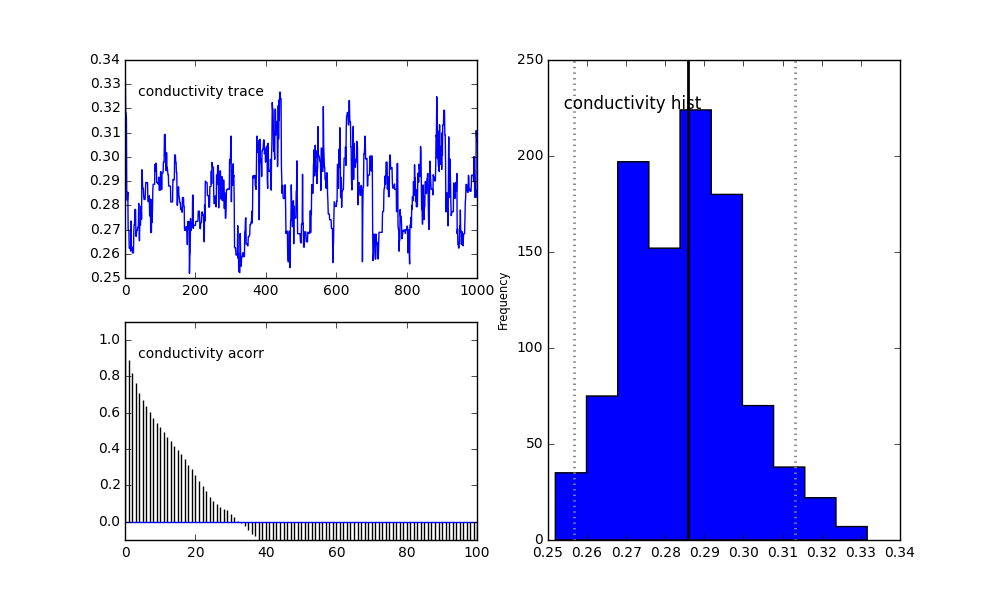

In [12]:
pm.Matplot.plot(k_pm)
Image(filename = 'figures/conductivity.png', width = 600)

This built-in `plot` function shows three graphs that we can use to assess the validity of a posterior distribution:
* The upper left panel shows the **trace** of the parameter at hand (accounting for the burn-in and thinning that have been specified for the sampling). The trace should ideally look like noise: the graph shows whether it is the case, or if we need a longer burn-in period or additional iterations.
* The lower left panel shows the **autocorrelation** of the trace. Should it not decrease quickly enough, additional thinning may be appropriate.
* The right panel shows the **histogram** of the trace, aka the posterior distribution, its conditional mean and 95% confidence intervals.

### Posterior distributions

If the validity of the trace is confirmed by the two left panels, then we may consider the graph on the right as representative of the **posterior distribution** of this specific variable: the inference is successful (which is not the same as saying the results are good).

You may retrieve the posterior distributions of our 4 unknowns by recording their traces as such:

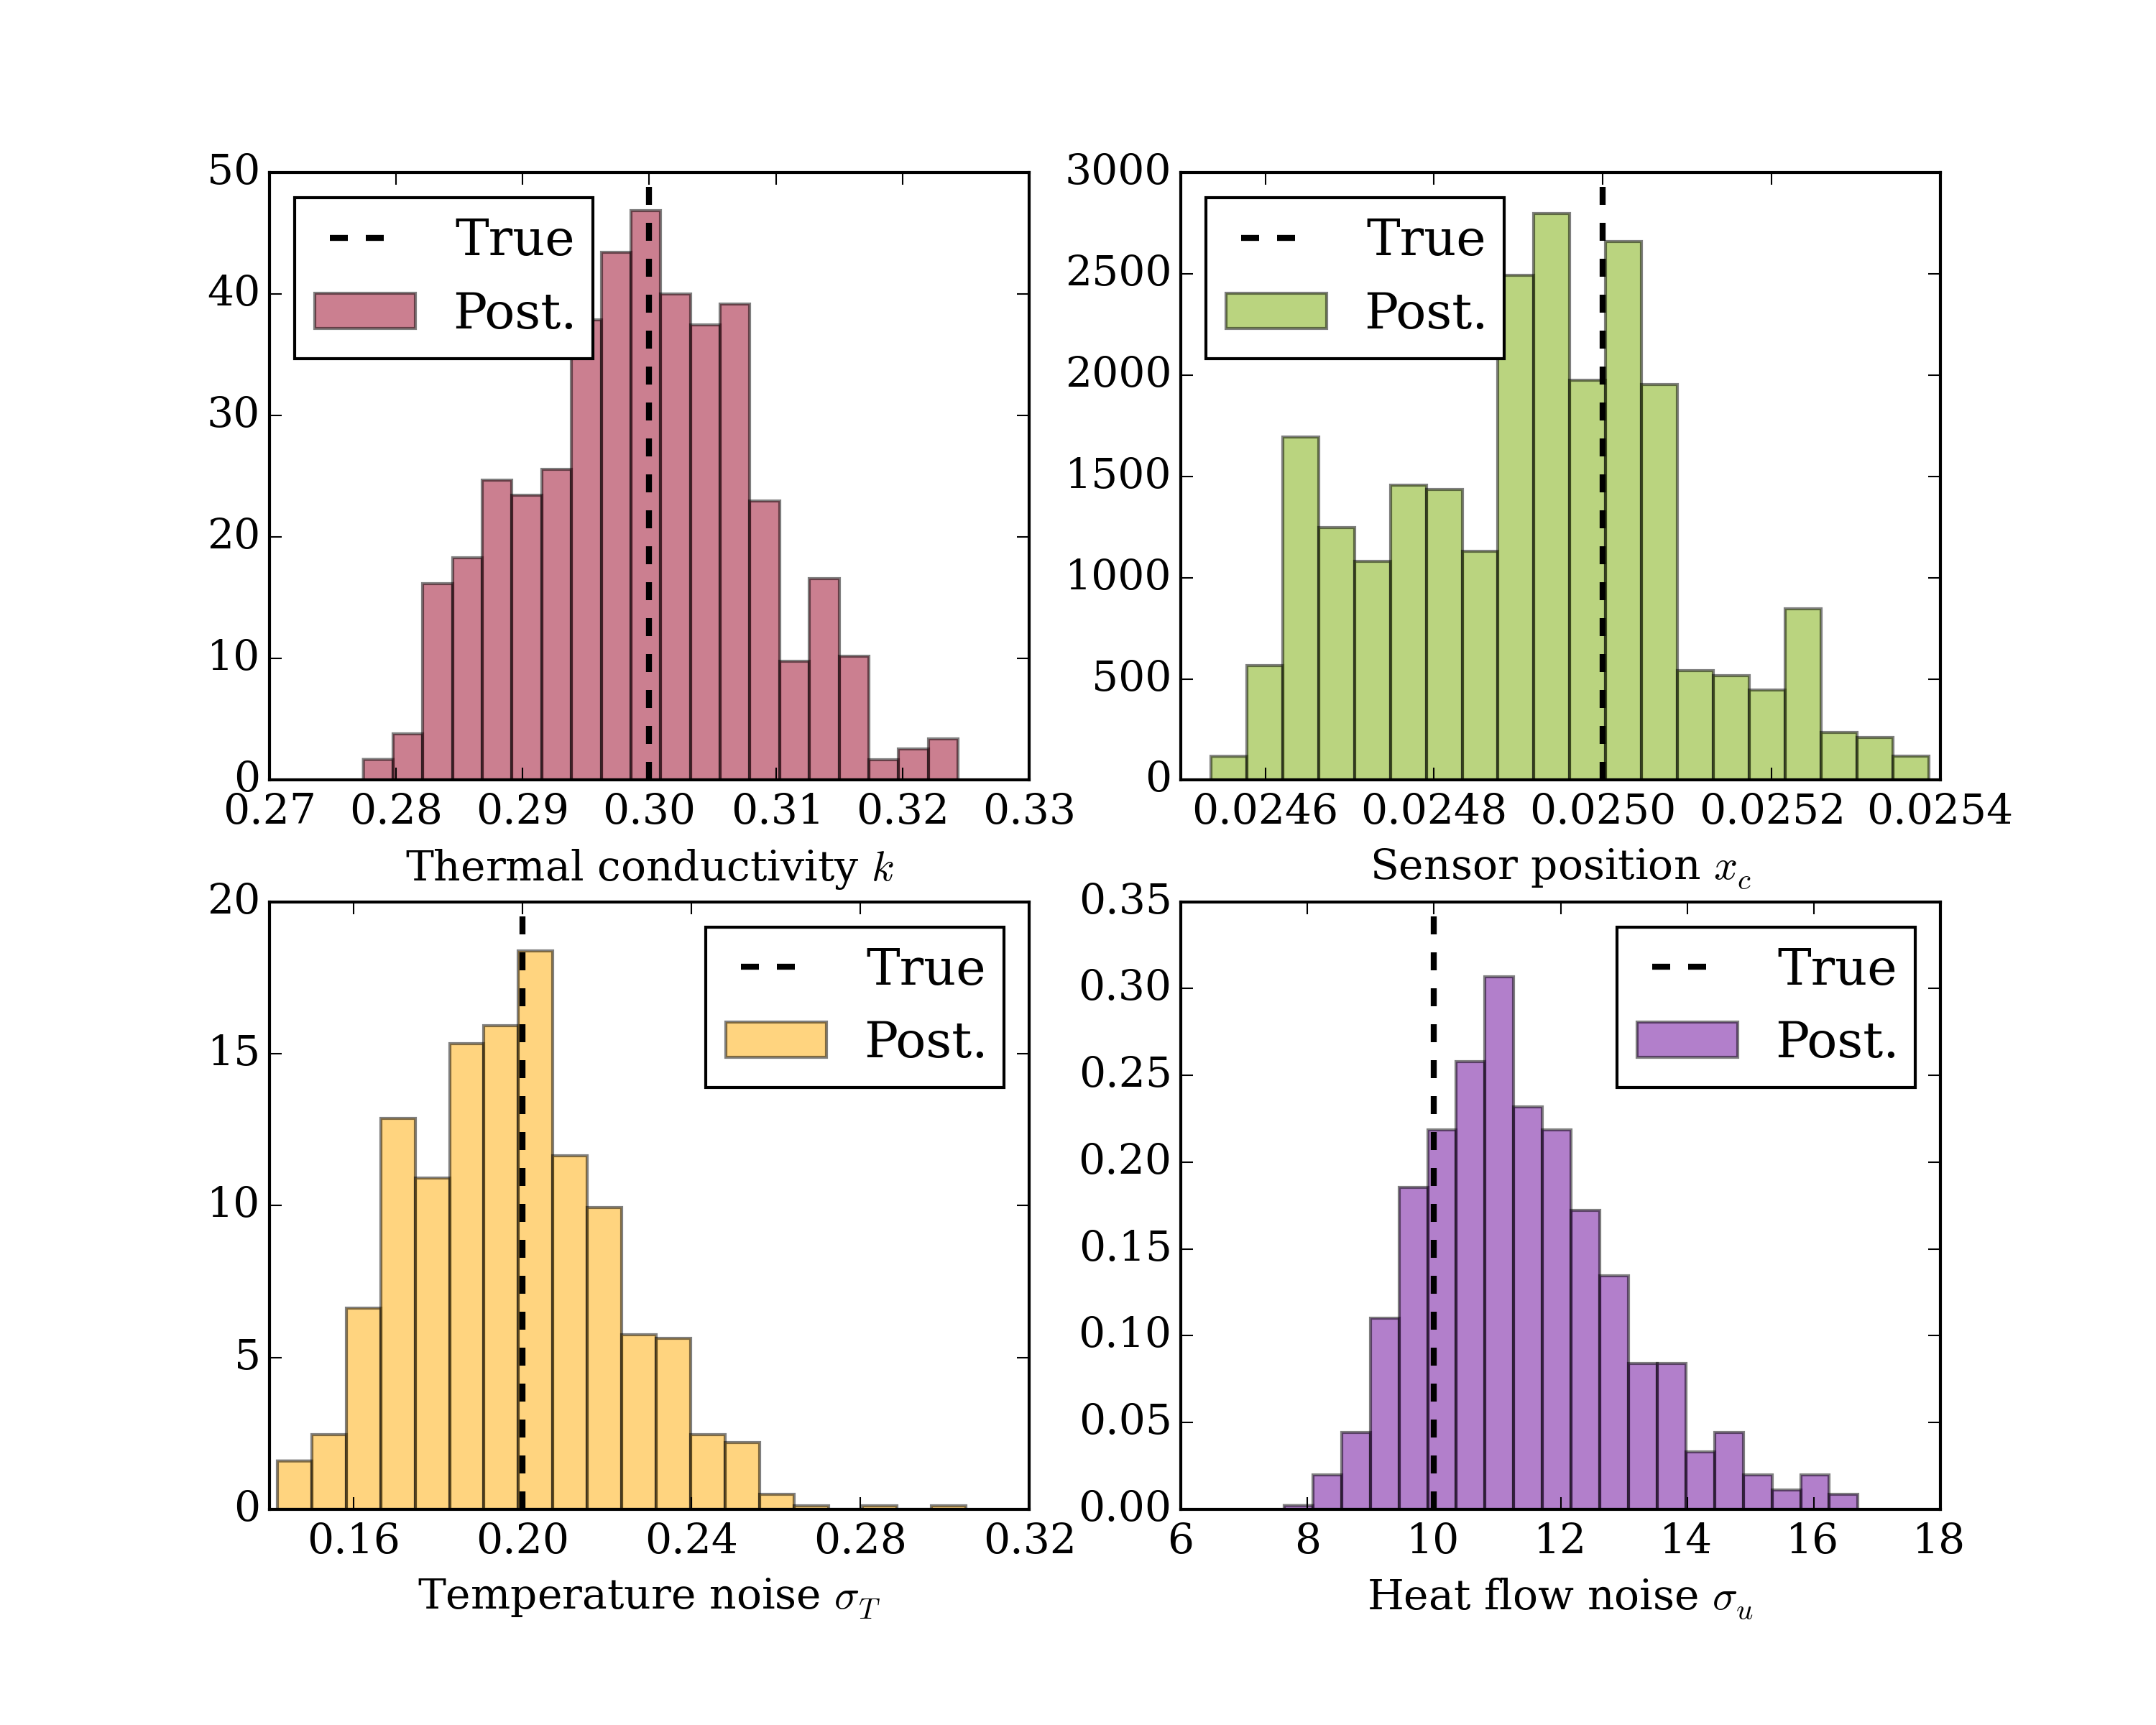

In [13]:
k_samples = R.trace('conductivity')[:]
sigma_T_samples = R.trace('temperature noise')[:]
sigma_u_samples = R.trace('heat flow noise')[:]
xc_samples = R.trace('sensor position')[:]

Image(filename = 'figures/posteriors.png', width = 800)

Compared to the real values of the parameters we were looking for, these distributions are substantially more precise than the initial prior distributions we started from. We can assume that the inference has been a success.